In [2]:
#!pip install --upgrade pip setuptools wheel
#!python -m pip install opencv-python
#!pip install matplotlib
#!pip freeze
#!pip install opencv-python-headless
#!pip install scikit-image
#!pip install -U scikit-fuzzy
#!pip install pandas
#!pip install scikit-learn
#!pip install tqdm==4.40.0

from matplotlib import pyplot as plt
import cv2
import os
import random
import pandas as pd
import numpy as np
from os.path import join
from skimage import measure
from skimage.feature import blob_dog, blob_log, blob_doh
import skfuzzy as fuzz
import library

### IMAGE PROCESSING - PREPROCESSING

In [ ]:
# from bansal paper laplacian of gaussian + top hat morphology
# NOT FINISHED!!!!!!
def hairRemoval_LoG_THM(matrix, ksize = 3, kernel_size = 17, filterSize = (11, 11)):
    # 1. grayscale
    gray = cv2.cvtColor(matrix, cv2.COLOR_BGR2GRAY)
    
    # 2. laplacian of gaussian
    # steps are blurring,
    #           laplacian,
    #           zero_crossing,
    #           threshold zero crossing to extract strong edges
    ddepth = cv2.CV_16S
    blur = cv2.GaussianBlur(gray, (ksize, ksize), 0)
    lp = cv2.Laplacian(blur, ddepth, ksize=ksize)
    # converting output back to uint8
    log = cv2.convertScaleAbs(lp)

    # 3. closing and dilation
    kernel = cv2.getStructuringElement(1,(kernel_size,kernel_size))
    close = cv2.morphologyEx(log, cv2.MORPH_CLOSE, kernel)
    dil = cv2.dilate(close, kernel)
    
    # 4. top-hat transformation   
    kernel_th = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                          filterSize)
    
    tophat = cv2.morphologyEx(dil, 
                              cv2.MORPH_TOPHAT,
                              kernel_th)
    # 5. otsu
    #thresh = cv2.threshold(sharp, 0, 255, cv2.THRESH_OTSU )[1]
    # 6. erosion and closing
    # 7. impainting
    
    return log, close, dil, tophat

# MAIN

First pipeline with 

- hair removal
- segmentation with kmeans
- extracting asymmetry from the images

In [ ]:
FOLDER_DIR = "/home/emily/Desktop/CAD/challenge1/train"

# img = cv2.imread(join(FOLDER_DIR,"nevus", "nev{}.jpg".format("03178")))
img = cv2.imread(join(FOLDER_DIR, "others", "{}.jpg".format("ack00322")))
# 00656 02056 01831 00547 02237  02462 02655  03178 03284   04438  05209 bcc00220 bcc00242
# 04762 04176 cute
# 00246 05464 02758 02462 02379 shity
# 03863 finger
# others ack00291 ack00363 bcc00001 bc00103 ack00028 ack00180 ack00322 bcc00221 bcc00271 bkl00160 ack00021
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

nevus = np.array(img_rgb)
plt.imshow(img_rgb)
plt.title('original')
plt.show()

output_bh = library.hair_removal_BH(img)

plt.imshow(cv2.cvtColor(output_bh, cv2.COLOR_BGR2RGB))
plt.title('preprocessing blackhat')
plt.show()


mask = segmentation_kmeans(output_bh)

plt.imshow(mask, cmap='gray')
plt.title('mask')
plt.show()

asy = asymmetry(mask, False)
print('asymmetry value: ', asy)

# FEATURES EXTRACTION

## ABCD Rule

commonly used feature extraction method from dermoscopic images is based on the ABCD rule of dermatoscopu nachbar et al 1994.  this method consider 4 criteria: 

- asymmetry: if you draw a like through the half of the mole and the halfs are different. its asymetrical
- border structure
- color variation
- diameter of skin lesion.

inspiration for code from

https://github.com/sohum2002/melanoma-detection/blob/master/melanoma/feature_extraction/asymmetry_index.py
https://github.com/hadikhanhk786/melanoma-detection-python/blob/master/src/Lesion.py
https://github.com/RCharradi/Melanoma-detection-from-dermoscopy-images-

 ### ASYMMETRY


In [ ]:
# https://github.com/sohum2002/melanoma-detection/blob/master/melanoma/feature_extraction/asymmetry_index.py

def checkOverlap(shape1, shape2):
    #Find the accuracy of symmetry
    all_pixels = 0.
    correct = 0.
    wrong = 0.

    for i in range(shape1.shape[0]):
        for j in range(shape1.shape[1]):

            curr_pixel1 = (shape1[i][j])
            curr_pixel2 = (shape2[i][j])

            if(curr_pixel1 or curr_pixel2):
                all_pixels += 1
                if(curr_pixel1 and curr_pixel2):
                    correct += 1
                else:
                    wrong += 1

    return correct, wrong, all_pixels

def asymmetry(mask, flag):
    
    # 0. variables
    x = []
    y = []
    top  = np.zeros((mask.shape[0], mask.shape[1]), dtype=bool)
    left = np.zeros((mask.shape[0], mask.shape[1]), dtype=bool)
    bottom = np.zeros((mask.shape[0], mask.shape[1]), dtype=bool)
    right = np.zeros((mask.shape[0], mask.shape[1]), dtype=bool)
    
    # 1. find the center of the image
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if (mask[i][j] != 1):
                x.append(j)
                y.append(i)
    
    # centroid = ( gray.shape[0] / 2, gray.shape[1] / 2) # need to change if segmentation maskk
    centroid = (sum(x) / len(x), sum(y) / len(y))
    print('centroid ', centroid)
    
    # print(np.unique(mask))
    
    # 2. split top/down images
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if (mask[i][j] < 1):
                if (i < centroid[1]):
                    top[i][j] = True
    if flag:
        plt.imshow(top)
        plt.title('top')
        plt.show()
    
    # 4. split left/right images
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if (mask[i][j] < 0.95):
                if (j < centroid[0]):
                    left[i][j] = True
    if flag:
        plt.imshow(left)
        plt.title('left')
        plt.show()
    
    # doing for flip top/down images
    flipped_ud = np.flipud(mask)
    
    for i in range(flipped_ud.shape[0]):
        for j in range(flipped_ud.shape[1]):
            if(flipped_ud[i][j] < 0.95):
                if(i < centroid[1]):
                    bottom[i][j] = True
    
    if flag:
        plt.imshow(bottom)
        plt.title('bottom')
        plt.show()
    
    # doing for flip left/right to get the right part
    flipped_lr = np.fliplr(mask)
    
    # performing splitting for top/down images
    for i in range(flipped_lr.shape[0]):
        for j in range(flipped_lr.shape[1]):
            if(flipped_lr[i][j] < 0.95):
                if(j < centroid[0]):
                    right[i][j] = True
    if flag:
        plt.imshow(right)
        plt.title('right')
        plt.show()        
        
    correct_TB, wrong_TB, all_TB = checkOverlap(top, bottom)
    correct_LR, wrong_LR, all_LR = checkOverlap(left, right)
    
    if flag:
        print(correct_TB)
        print(all_TB)
        print(correct_LR)
        print(all_LR)
    
    return 1- sum([correct_TB / all_TB, correct_LR / all_LR]) / 2

result_asym = asymmetry(mask, True)

print('symmetry ', result_asym)

### GENERATING FEATURES

In [33]:
#https://stackoverflow.com/questions/25008458/how-to-apply-clahe-on-rgb-color-images
def clahe_rgb(img, gridsize=100):

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

    lab_planes = np.array([map(list, lab_planes)])
    
    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    result = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return result

2
count  0
hairless


/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/emily/.l

count  1
hairless


/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/emily/.l

/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/emily/.local/lib/python3.10/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/home/emily/.loc

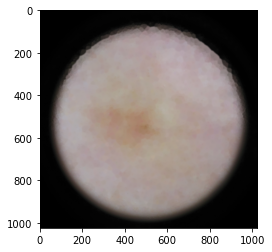

In [5]:
import library
import texture_features
import color_features
import glcm_features
import hair_removal
import pandas as pd
import numpy as np
import cv2
import os

samples = library.get_sample(path = "/home/emily/Desktop/CAD/challenge1/train", amount=2)

dictF = {}
features = pd.DataFrame()
count = 0
flag = True

for sample in samples:
    print('count ', count)
    count += 1
    
    # read image
    img = cv2.imread(sample)
    
    plt.imshow(img)

    # clahe preprocessing
    #clahe = clahe_rgb(img, 8)
    
    # gray world. color balanced
    #prepro = library.grey_world(img)
    prepro = img
    
    # hair removal
    output_bh = hair_removal.hair_remove(prepro, 17, 4)
    print("hairless")
    
    dictF['name'] = sample
    dictF['label'] = (0 if 'nevus' in sample else 1 )
    
    # color features
    colors = color_features.extract_color_features(prepro)
    dictF.update(colors)
    
    # glcm features
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    distances = [1]
    colorspaces = ['rgb', 'hsv', 'lab', 'ycc', 'gray']
    
    for cs in colorspaces:
        glcm = glcm_features.get_glcm(prepro, angles, distances, cs)
        dictF.update(glcm)
    
    
    # lbp features
    lbp = texture_features.extract_lbp(prepro, 1, 8)
    dictF.update(lbp)
    
    # orb features
    # orb = texture_features.extract_orb(output_bh, 64)
    # dictF.update(orb)
    
    features = features.append(dictF, ignore_index=True)
    
    # save features
    library.writeFeatures(features,
                  flag,
                  os.path.join('/home',
                             'emily',
                             'Desktop',
                             'CAD'),
                  'features_prepro_shaver_4.csv')
    
    flag = False
    features = pd.DataFrame()
    dictF.clear()


# MACHINE LEARNING

In [4]:
import os
import library
import pandas as pd
from sklearn import tree
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif    

#
classifiers = ["rf", "tree", "svm", "adaboost", "gradboost", "histgradboost", "knn", "lda"]

train = pd.read_csv(os.path.join('/home','emily','Desktop','CAD','MelanomaChallenge','features','features_train_bh_3000.csv'))
test = pd.read_csv(os.path.join('/home','emily','Desktop','CAD','MelanomaChallenge','features','features_test_bh_3000.csv'))

y = train['label']
X = train.drop(['label'], axis=1)
X = X.drop(['name'], axis=1)


y_test = test['label']
X_test = test.drop(['label'], axis=1)
X_test = X_test.drop(['name'], axis=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=1)

# preprocessing options
#('selectFromModel', SelectFromModel(RandomForestClassifier(random_state=42, n_jobs = -1)))
#('selector rfe', RFE(RandomForestClassifier(random_state=42, n_jobs = -1))),
#('reduce_dims', PCA(n_components=150)),
#('mutual_info_classif, SelectKBest(mutual_info_classif, k=100)),

for classifier in classifiers:
    
    # preprocessing steps
    pipe = [('scale', StandardScaler()),
            ('selector rfe', RFE(RandomForestClassifier(random_state=42, n_jobs = -1)))
           ]

    
    if classifier == "svm":
        clf, best_params = library.SVC_linear(X_val, y_val, cv=2)
        clf.set_params(**best_params)
        print("### SVM ###")
    
    elif classifier == "rf":
        clf, best_params = library.RandomForest(X_val, y_val, cv=2)
        clf.set_params(**best_params)
        print("### RF ###")
    
    elif classifier == "tree":
        clf = tree.DecisionTreeClassifier()
        print("### TREE ###")
    
    elif classifier == "adaboost":
        clf, best_params = library.AdaBoost(X_val, y_val)
        clf.set_params(**best_params)
        print("### ADABOOST ###")
    
    elif classifier == "gradboost":
        clf, best_params = library.GradientBoosting(X_val, y_val)
        clf.set_params(**best_params)
        print("### GRADBOOST ###")
    
    elif classifier == "knn":
        clf, best_params = library.knn(X_val, y_val)
        clf.set_params(**best_params)
        print("### KNN ###")
        
    elif classifier == "histgradboost":
        clf = HistGradientBoostingClassifier()
        print("### HISTGRADBOOST ###")
        
    elif classifier == "lda":
        clf = LinearDiscriminantAnalysis()
        print("### LDA ###")        
        
    # add classifier 
    pipe.append(tuple(('clf', clf)))
    
    steps = Pipeline(pipe)
    
    # pipeline shape
    print("current pipeline")
    print(steps)
    
    library.fit_report(steps, X, y, X_test, y_test)
    

Searching for best hyperparameters
The best parameters for rf are {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 500} with an accuracy of 0.7367
### RF ###
current pipeline
Pipeline(steps=[('scale', StandardScaler()),
                ('selector rfe',
                 RFE(estimator=RandomForestClassifier(n_jobs=-1,
                                                      random_state=42))),
                ('clf',
                 RandomForestClassifier(max_depth=10, n_estimators=500,
                                        n_jobs=-1, random_state=42))])
###############
 ### Report ###
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1198
           1       0.75      0.83      0.79      1202

    accuracy                           0.78      2400
   macro avg       0.78      0.78      0.78      2400
weighted avg       0.78      0.78      0.78      2400

 ### score ###
0.7808333333333334
 ### accuracy ###
0.7808333333333334
### f